# Online Retail Analysis

In [1]:
import pandas as pd
import numpy as np

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.colors as mcolors

# Data import, basic cleaning and diagnostics

In [11]:
df = pd.read_excel('online_retail_II.xlsx')

In [12]:
# Deduplication, selection and time transformation

df.drop_duplicates(keep='first', inplace=True, ignore_index=False)
df = df[df['Customer ID'].notna()]
df.InvoiceDate = pd.to_datetime(df.InvoiceDate, infer_datetime_format=True)

In [4]:
c_name = 'Column name'
c_type = 'Type'
n_counts = 'Counts'
n_missing = 'Missing'
n_unique = 'Cardinality'
n_negative = 'Negative'
n_zero = 'Zero'
skewness = 'Skewness'
max_dev = 'Max|Deviation|'

variables_num = list(df.select_dtypes(include=np.number).columns)

print('====================')
print('Numerical variables')
print(f"Total: {len(variables_num)}")
print('=============================================================================================================')
print(f"{c_name:<20}{c_type:<13}{n_counts:<10}{n_missing:<10}{n_unique:<15}{n_negative:<10}{n_zero:<10}{skewness:<10}\
{max_dev:<15}")
print('=============================================================================================================')

for v in variables_num:
    print(f"{v:<20}{str(df[v].dtype):<13}{df[v].count():<10}{df[v].isna().sum():<10}{df[v].nunique():<15}\
    {df[df[v]<0][v].count():<10}{df[df[v]==0][v].count():<10}{np.round(df[v].skew(),3):<10}{abs((df[v]-df[v].mean())/df[v].std()).max():<15.3}")

Numerical variables
Total: 3
Column name         Type         Counts    Missing   Cardinality    Negative  Zero      Skewness  Max|Deviation| 
Quantity            int64        410763    0         500                9816      0         62.216    1.88e+02       
Price               float64      410763    0         664                0         31        182.466   3.5e+02        
Customer ID         float64      410763    0         4383               0         0         -0.011    1.79           


In [5]:
# Print summary for non-numerical variables

variables_cat = list(df.select_dtypes(exclude=np.number).columns)

print('========================')
print('Non-numerical variables')
print(f"Total: {len(variables_cat)}")
print('========================================================================')
print(f"{c_name:<20}{c_type:<15}{n_counts:<10}{n_missing:<10}{n_unique:<15}")
print('========================================================================')

for v in variables_cat:
    print(f"{v:<20}{str(df[v].dtype):<15}{df[v].count():<10}{df[v].isna().sum():<10}{df[v].nunique():<15}")

Non-numerical variables
Total: 5
Column name         Type           Counts    Missing   Cardinality    
Invoice             object         410763    0         23587          
StockCode           object         410763    0         4031           
Description         object         410763    0         4459           
InvoiceDate         datetime64[ns] 410763    0         21786          
Country             object         410763    0         37             


# Some feature engineering

Identifying cancellations and computing the overall transaction price.

In [139]:
df['Cancellation'] = df.Invoice.apply(lambda x: str(x)[0]=='C')
df['Quantity'] = abs(df.Quantity)
df['Transaction Price'] = df.Quantity*df.Price

In [243]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Cancellation,Transaction Price,Customer Cancellation Rate,Customer With Cancellations
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,False,83.40,0.015873,True
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,81.00,0.015873,True
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,81.00,0.015873,True
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,False,100.80,0.015873,True
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,False,30.00,0.015873,True
...,...,...,...,...,...,...,...,...,...,...,...,...
410758,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,False,5.90,0.006536,True
410759,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,False,3.75,0.006536,True
410760,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,False,3.75,0.006536,True
410761,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,False,7.50,0.006536,True


## Analyse customer cancellations

How many customers have ever cancelled a transaction?

In [64]:
df.groupby('Customer ID').Cancellation.apply(lambda x: True in list(x)).value_counts()

False    2585
True     1798
Name: Cancellation, dtype: int64

For each customer store the info whether they ever cancelled a transaction.

In [238]:
customer_canc = pd.DataFrame(df.groupby('Customer ID').Cancellation.apply(lambda x: True in list(x))).rename(columns={'Cancellation': 'Customer With Cancellations'})
tmp = pd.DataFrame(df.groupby('Customer ID').Cancellation.apply(lambda x: sum(list(x))/len(list(x)))).rename(columns={'Cancellation': 'Customer Cancellation Rate'})
customer_canc = pd.merge(customer_canc, tmp, how='left', on='Customer ID')

In [239]:
customer_canc

,Customer With Cancellations,Customer Cancellation Rate
Customer ID,,
12346.0,True,0.266667
12347.0,False,0.000000
12348.0,False,0.000000
12349.0,True,0.046729
12351.0,False,0.000000
...,...,...
18283.0,False,0.000000
18284.0,True,0.034483
18285.0,False,0.000000


Merge the info into the main df.

In [224]:
df = pd.merge(df, customer_canc, how='left', on='Customer ID')

Fraction of cutomers that have ever made a cancellation:

In [240]:
customer_canc.sum()/customer_canc.count()

Customer With Cancellations    0.410221
Customer Cancellation Rate     0.043115
dtype: float64

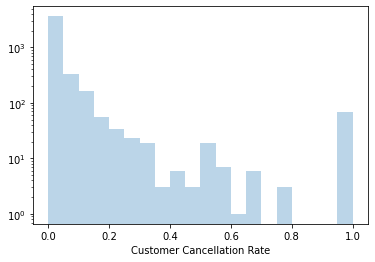

In [242]:
plt.hist(customer_canc['Customer Cancellation Rate'],\
         bins=20, alpha=0.3)
plt.xlabel('Customer Cancellation Rate')
plt.yscale('log')
plt.show()

In [805]:
customer_canc['Customer Cancellation Rate'].sort_values(ascending=False)

Customer ID
12706.0    1.0
16703.0    1.0
15997.0    1.0
16151.0    1.0
16154.0    1.0
          ... 
15034.0    0.0
15037.0    0.0
15038.0    0.0
15040.0    0.0
15456.0    0.0
Name: Customer Cancellation Rate, Length: 4383, dtype: float64

## Analyse customers that already made cancellations

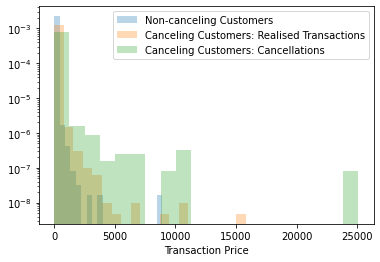

In [229]:
plt.hist(df.query('`Customer With Cancellations`!=True')['Transaction Price'],\
         bins=20, alpha=0.3, density=True, label='Non-canceling Customers')
plt.hist(df.query('`Customer With Cancellations`==True and Cancellation!=True')['Transaction Price'],\
         bins=20, alpha=0.3, density=True, label='Canceling Customers: Realised Transactions')
plt.hist(df.query('`Customer With Cancellations`==True and Cancellation==True')['Transaction Price'],\
         bins=20, alpha=0.3, density=True, label='Canceling Customers: Cancellations')
plt.legend()
plt.xlabel('Transaction Price')
plt.yscale('log')
plt.show()

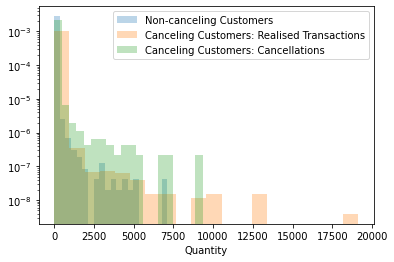

In [87]:
plt.hist(df.query('`Customer With Cancellations`!=True')['Quantity'],\
         bins=20, alpha=0.3, density=True, label='Non-canceling Customers')
plt.hist(df.query('`Customer With Cancellations`==True and Cancellation!=True')['Quantity'],\
         bins=20, alpha=0.3, density=True, label='Canceling Customers: Realised Transactions')
plt.hist(df.query('`Customer With Cancellations`==True and Cancellation==True')['Quantity']*(-1),\
         bins=20, alpha=0.3, density=True, label='Canceling Customers: Cancellations')
plt.legend()
plt.xlabel('Quantity')
plt.yscale('log')
plt.show()

Insights:
- Customers that have never made a cancellation make transactions with smaller quantities and lower prices.
- Customers that make cancellations tend to cancel transactions with larger quantities and higher total price.

## Analyse products

A quick sanity check: do stock code and description have a 1-to-1 correpondance? Answer: no.

In [25]:
df.groupby('StockCode').Description.apply(lambda x: x.nunique()).unique()

array([1, 2, 4, 3])

In [26]:
df.groupby('StockCode').Description.apply(lambda x: x.nunique()).value_counts()

1    3607
2     398
3      20
4       6
Name: Description, dtype: int64

In [27]:
df.groupby('Description').StockCode.apply(lambda x: x.nunique()).unique()

array([1, 2, 3])

In [28]:
df.groupby('Description').StockCode.apply(lambda x: x.nunique()).value_counts()

1    4434
2      22
3       3
Name: StockCode, dtype: int64

Another sanity check: does a product (defined either by the description or StockCode) always have the same price?

In [96]:
df.groupby('Description').Price.apply(lambda x: set(x))

Description
  DOORMAT UNION JACK GUNS AND ROSES                  {5.95, 6.75}
 3 STRIPEY MICE FELTCRAFT                            {1.95, 1.65}
 4 PURPLE FLOCK DINNER CANDLES                       {0.85, 2.55}
 ANIMAL STICKERS                                           {0.21}
 BLACK PIRATE TREASURE CHEST                               {1.65}
                                                  ...            
ZINC HEART LATTICE TRAY OVAL                          {0.5, 5.95}
ZINC METAL HEART DECORATION                          {1.25, 1.06}
ZINC POLICE BOX LANTERN                               {4.0, 5.95}
ZINC TOP  2 DOOR WOODEN SHELF          {16.95, 2.95, 3.95, 14.95}
ZINC WILLIE WINKIE  CANDLE STICK                     {0.85, 0.72}
Name: Price, Length: 4459, dtype: object

In [101]:
df.groupby('StockCode').Price.apply(lambda x: set(x))

StockCode
10002                                           {0.85, 0.72}
10080                                                 {0.85}
10109                                                 {0.42}
10120                                                 {0.21}
10125                                                 {0.85}
                                 ...                        
PADS                                           {36.6, 0.001}
POST       {1.0, 2.99, 130.0, 4.0, 5.0, 4.41, 7.06, 8.97,...
SP1002                                                {2.95}
TEST001                                           {0.0, 4.5}
TEST002                                                {1.0}
Name: Price, Length: 4031, dtype: object

Insight: the price of a product can in some cases vary quite a lot.

How frequently is a particular product being cancelled?

In [102]:
df.groupby('Description').Cancellation.apply(lambda x: sum(list(x))/len(list(x))).sort_values(ascending=False).head(50)

Description
BLUE GREEN CHRISTMAS HANGING BALL      1.000000
VINTAGE BLUE VACUUM FLASK 0.5L         1.000000
PURPLE ORCHID FLOWER LIGHTS            1.000000
SET 6 MINI SUSHI SET FRIDGE MAGNETS    1.000000
HAND OPEN SHAPE CHROME                 1.000000
SET OF KITCHEN WALL  STICKERS          1.000000
ENGLISH ROSE DESIGN KITCHEN APRON      1.000000
Adjustment by Peter on 24/05/2010 1    1.000000
WHITE ORCHID FLOWER LIGHTS             1.000000
ZINC HEART HANGER WITH HOOKS           1.000000
S/4 HEART CRYSTAL FRIDGE MAGNETS       1.000000
PINK EAR MUFF HEADPHONES               1.000000
LARGE GLASS HEART TRINKET POT          1.000000
LARGE SILVER BALUSTRADE CANDLESTICK    1.000000
VINTAGE WOOD ORGANISER                 1.000000
Discount                               0.948454
FEATHER HEART LIGHTS                   0.800000
RED HEART CANDY POP LIGHTS             0.750000
CREAM SWEETHEART DOUBLE SHELF          0.666667
CAMOUFLAGE BACKPACK ON WHEELS          0.666667
CERAMIC CAKE TEAPOT WITH CHE

In [103]:
df.groupby('StockCode').Cancellation.apply(lambda x: sum(list(x))/len(list(x))).sort_values(ascending=False).head(50)

StockCode
21254     1.000000
21315     1.000000
21346     1.000000
22003     1.000000
79340P    1.000000
79340W    1.000000
35631B    1.000000
21053     1.000000
21766     1.000000
85219     1.000000
35001C    1.000000
20779     1.000000
47567     1.000000
21701     1.000000
D         0.948454
79301     0.800000
85043     0.750000
85069     0.666667
78056     0.666667
37451     0.666667
79323B    0.505263
22722     0.500000
79065A    0.500000
20822     0.500000
47569     0.500000
22850     0.500000
21475     0.500000
20791     0.500000
21950     0.500000
40002     0.500000
20885     0.500000
47504J    0.500000
21496     0.500000
35603B    0.500000
20715     0.500000
35976B    0.500000
ADJUST    0.475410
44217M    0.400000
90176C    0.400000
M         0.346273
84967A    0.333333
90049     0.333333
85083     0.333333
84679     0.333333
35001P    0.333333
85159A    0.333333
17013C    0.333333
37488A    0.333333
85185E    0.333333
84611B    0.333333
Name: Cancellation, dtype: float64

Is there a dependence between the average unit price of a product and its cancellation rate?

In [246]:
df_prod = pd.DataFrame(df.groupby('StockCode').Cancellation.\
                       apply(lambda x: sum(list(x))/len(list(x))).\
                       sort_values(ascending=False)).rename(columns={'Cancellation': 'Product Cancellation Rate'})#.dropna(inplace=True)

tmp = pd.DataFrame(df.groupby('StockCode').Price.agg('mean')).rename(columns={'Price': 'Product Price Mean'})
df_prod = pd.concat([df_prod, tmp], axis=1)

tmp = pd.DataFrame(df.groupby('StockCode')['Transaction Price'].agg('mean')).rename(columns={'Transaction Price': 'Product Transaction Price Mean'})
df_prod = pd.concat([df_prod, tmp], axis=1)

Text(0, 0.5, 'Cancellation Rate')

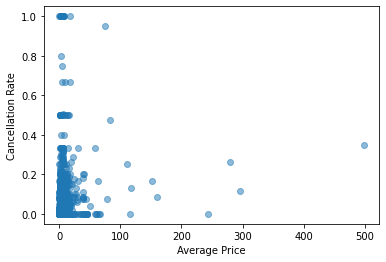

In [248]:
plt.scatter(df_prod['Product Price Mean'], df_prod['Product Cancellation Rate'], alpha=0.5)
plt.xlabel('Average Price')
plt.ylabel('Cancellation Rate')
#plt.title()

In [249]:
print(f'Correlation coefficient:')
print(df_prod['Product Price Mean'].corr(df_prod['Product Cancellation Rate']))

Correlation coefficient:
0.1420710455048556


In [250]:
print(f'Correlation coefficient regardless the outliers:')
print(df_prod.query('`Product Price Mean`<50')['Product Price Mean'].corr(df_prod['Product Cancellation Rate']))

Correlation coefficient regardless the outliers:
0.1436433404519347


Text(0, 0.5, 'Cancellation Rate')

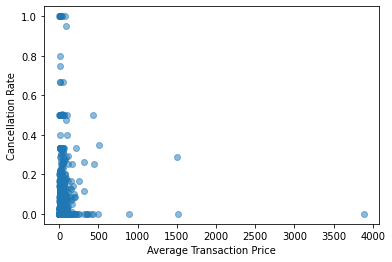

In [251]:
plt.scatter(df_prod['Product Transaction Price Mean'], df_prod['Product Cancellation Rate'], alpha=0.5)
plt.xlabel('Average Transaction Price')
plt.ylabel('Cancellation Rate')
#plt.title()

In [252]:
print(f'Correlation coefficient:')
print(df_prod['Product Transaction Price Mean'].corr(df_prod['Product Cancellation Rate']))

Correlation coefficient:
0.05745083693282338


In [253]:
print(f'Correlation coefficient regardless the outliers:')
print(df_prod.query('`Product Transaction Price Mean`<200')['Product Transaction Price Mean'].corr(df_prod['Product Cancellation Rate']))

Correlation coefficient regardless the outliers:
0.12544196279210443


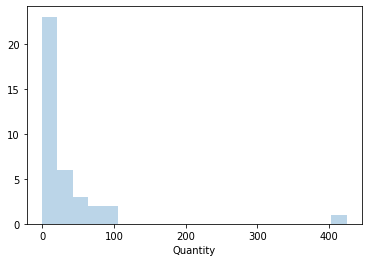

In [254]:
plt.hist(df_prod.query('`Product Cancellation Rate`>0.4')['Product Transaction Price Mean'],\
         bins=20, alpha=0.3)
plt.xlabel('Quantity')
plt.show()

Insight: globally there is not much correlation between the cancellation rate and the mean unit price or total transaction price of a product. However, it is rather cheap products that have very high cancellation rates.

In [257]:
df = pd.merge(df, df_prod['Product Cancellation Rate'], how='left', on='StockCode')

In [256]:
df_prod

,Product Cancellation Rate,Product Price Mean,Product Transaction Price Mean
StockCode,,,
21254,1.0,2.950000,11.800000
21315,1.0,4.250000,17.000000
21346,1.0,5.950000,5.950000
22003,1.0,6.750000,67.500000
79340P,1.0,7.950000,7.950000
...,...,...,...
48103,0.0,7.051000,20.173000
48116,0.0,7.088699,43.896098
48129,0.0,7.243450,42.247604


## Temporal distribution of cancellations

In [176]:
print(f'The earliest date:')
print(df['InvoiceDate'].min())
print()
print(f'The latest date:')
print(df['InvoiceDate'].max())

The earliest date:
2009-12-01 07:45:00

The latest date:
2010-12-09 20:01:00


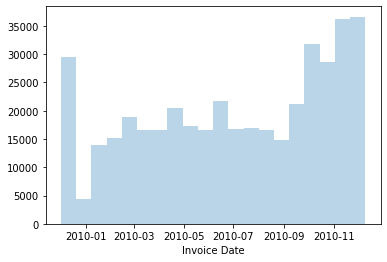

In [482]:
plt.hist(df['InvoiceDate'],\
         bins=20, alpha=0.3)
plt.xlabel('Invoice Date')
plt.show()

## Churn prediction

In [293]:
# Sanity checks
df.groupby('Customer ID')['Customer Cancellation Rate'].apply(lambda x: len(set(x))).unique()
df.groupby('Customer ID')['Customer With Cancellations'].apply(lambda x: len(set(x))).unique()

array([1])

Make a dataframe aggregated per customer.

In [766]:
df_customer = pd.DataFrame(df.groupby('Customer ID').Quantity.agg(['sum', 'mean', 'min', 'max'])).rename(columns={'sum': 'Quantity Sum', 'mean': 'Quantity Mean', 'min': 'Quantity Min', 'max': 'Quantity Max'})

In [767]:
tmp = pd.DataFrame(df.groupby('Customer ID')['Price'].agg(['mean', 'min', 'max'])).rename(columns={'mean': 'Price Mean', 'min': 'Price Min', 'max': 'Price Max'})
df_customer = pd.merge(df_customer, tmp, how='left', on='Customer ID')

In [768]:
tmp = pd.DataFrame(df.groupby('Customer ID')['Transaction Price'].agg(['sum', 'mean', 'min', 'max'])).rename(columns={'sum': 'Transaction Price Sum', 'mean': 'Transaction Price Mean', 'min': 'Transaction Price Min', 'max': 'Transaction Price Max'})
df_customer = pd.merge(df_customer, tmp, how='left', on='Customer ID')

In [769]:
tmp = pd.DataFrame(df.groupby('Customer ID')['Customer Cancellation Rate'].apply(lambda x: list(x)[0]))
df_customer = pd.merge(df_customer, tmp, how='left', on='Customer ID')

In [770]:
tmp = pd.DataFrame(df.groupby('Customer ID')['Customer With Cancellations'].apply(lambda x: list(x)[0]))
df_customer = pd.merge(df_customer, tmp, how='left', on='Customer ID')

In [771]:
tmp = pd.DataFrame(df.groupby(['Customer ID']).Description.apply(list).apply(lambda l: max(set(l), key=l.count))).rename(columns={'Description': 'Most Frequent Product'})
df_customer = pd.merge(df_customer, tmp, how='left', on='Customer ID')

In [305]:
#pd.to_datetime(df.InvoiceDate.values.astype(np.int64).mean())

Timestamp('2010-06-30 19:56:14.853674752')

In [343]:
#tmp = pd.DataFrame(df.groupby('Customer ID')['InvoiceDate'].apply(lambda x: x.astype(np.int64).mean()/1.e18)).rename(columns={'InvoiceDate':'Invoice Date Mean'})
#df_customer = pd.merge(df_customer, tmp, how='left', on='Customer ID')                   
                   

In [344]:
#tmp = pd.DataFrame(df.groupby('Customer ID')['InvoiceDate'].apply(lambda x: x.astype(np.int64).min()/1.e18)).rename(columns={'InvoiceDate':'Invoice Date Min'})
#df_customer = pd.merge(df_customer, tmp, how='left', on='Customer ID')                   


In [345]:
#tmp = pd.DataFrame(df.groupby('Customer ID')['InvoiceDate'].apply(lambda x: x.astype(np.int64).max()/1.e18)).rename(columns={'InvoiceDate':'Invoice Date Max'})
#df_customer = pd.merge(df_customer, tmp, how='left', on='Customer ID')                   


In [772]:
tmp = pd.DataFrame(df.groupby('Customer ID')['Country'].apply(lambda x: list(x)[0])).rename(columns={'InvoiceDate':'Invoice Date Max'})
df_customer = pd.merge(df_customer, tmp, how='left', on='Customer ID')                   
#tmp

In [681]:
#df_customer['Country'].nunique()
#pd.get_dummies(df_customer['Country'])

37

In [751]:
#df_customer['Country'].value_counts()

In [339]:
#df_customer.drop(['Invoice Date Mean_y', 'Invoice Date Min_y', 'Invoice Date Max_y'], axis=1, inplace=True)

In [341]:
#df_customer.drop(['Invoice Date Mean'], axis=1, inplace=True)

In [773]:
df_customer['Customer With Cancellations'] = df_customer['Customer With Cancellations'].astype(np.int64)

<AxesSubplot:>

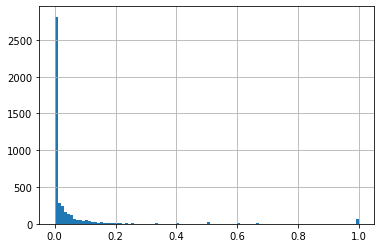

In [774]:
df_customer['Customer Cancellation Rate'].hist(bins=100)

In [806]:
df_customer

,Quantity Sum,Quantity Mean,Quantity Min,Quantity Max,Price Mean,Price Min,Price Max,Transaction Price Sum,Transaction Price Mean,Transaction Price Min,...,WOOD S/3 CABINET ANT WHITE FINISH,VICTORIAN GLASS HANGING T-LIGHT,SET/5 RED SPOTTY LID GLASS BOWLS,WOODEN FRAME ANTIQUE WHITE,CHOCOLATE HOT WATER BOTTLE,I CAN ONLY PLEASE ONE PERSON MUG,JUMBO STORAGE BAG SUKI,ASSORTED COLOURS SILK FAN,STRAWBERRY CHARLOTTE BAG,Cluster
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346.0,87,1.933333,1,10,12.564889,1.00,142.31,797.46,17.721333,1.00,...,False,False,False,False,False,False,False,False,False,1
12347.0,828,11.661972,3,36,2.295070,0.38,12.75,1323.32,18.638310,7.80,...,False,False,False,False,False,False,False,False,False,0
12348.0,373,18.650000,1,24,0.719500,0.29,1.45,222.16,11.108000,1.00,...,False,False,False,False,False,False,False,False,False,0
12349.0,998,9.327103,1,48,8.406449,0.42,250.00,2695.29,25.189626,1.25,...,False,False,True,False,False,False,False,False,False,0
12351.0,261,12.428571,1,25,2.355238,0.42,12.75,300.93,14.330000,9.90,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283.0,322,1.483871,1,12,2.199401,0.21,10.95,619.37,2.854240,0.21,...,False,True,False,False,False,True,True,False,True,2
18284.0,495,17.068966,1,50,4.003103,0.21,50.00,486.68,16.782069,6.30,...,False,False,False,False,False,False,False,False,False,0
18285.0,145,12.083333,1,80,8.350000,0.65,50.00,427.00,35.583333,7.80,...,False,True,False,False,False,False,False,False,False,0


### Most frequently purchased products

To incorporate the product information into customer segmentation, I will identify 20 most frequently purchased products, and for each of them produce a variable per costumer, telling whether the customer ever purchased that product.

In [776]:
df_customer['Most Frequent Product'].value_counts().head(30)

WHITE HANGING HEART T-LIGHT HOLDER    165
POSTAGE                                73
Manual                                 60
REGENCY CAKESTAND 3 TIER               58
HOME BUILDING BLOCK WORD               52
STRAWBERRY CERAMIC TRINKET BOX         47
BAKING SET 9 PIECE RETROSPOT           41
LUNCH BAG WOODLAND                     36
REX CASH+CARRY JUMBO SHOPPER           34
ASSORTED COLOUR BIRD ORNAMENT          32
JUMBO BAG STRAWBERRY                   30
WOOD S/3 CABINET ANT WHITE FINISH      30
VICTORIAN GLASS HANGING T-LIGHT        28
SET/5 RED SPOTTY LID GLASS BOWLS       27
WOODEN FRAME ANTIQUE WHITE             25
CHOCOLATE HOT WATER BOTTLE             24
I CAN ONLY PLEASE ONE PERSON MUG       23
JUMBO STORAGE BAG SUKI                 23
ASSORTED COLOURS SILK FAN              22
STRAWBERRY CHARLOTTE BAG               21
RED HANGING HEART T-LIGHT HOLDER       21
ANTIQUE SILVER TEA GLASS ENGRAVED      20
PACK OF 72 SKULL CAKE CASES            20
RED TOADSTOOL LED NIGHT LIGHT     

In [777]:
products = list(df_customer['Most Frequent Product'].value_counts().head(20).index)

In [778]:
products

['WHITE HANGING HEART T-LIGHT HOLDER',
 'POSTAGE',
 'Manual',
 'REGENCY CAKESTAND 3 TIER',
 'HOME BUILDING BLOCK WORD',
 'STRAWBERRY CERAMIC TRINKET BOX',
 'BAKING SET 9 PIECE RETROSPOT ',
 'LUNCH BAG WOODLAND',
 'REX CASH+CARRY JUMBO SHOPPER',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'JUMBO BAG STRAWBERRY',
 'WOOD S/3 CABINET ANT WHITE FINISH',
 'VICTORIAN GLASS HANGING T-LIGHT',
 'SET/5 RED SPOTTY LID GLASS BOWLS',
 'WOODEN FRAME ANTIQUE WHITE ',
 'CHOCOLATE HOT WATER BOTTLE',
 'I CAN ONLY PLEASE ONE PERSON MUG',
 'JUMBO STORAGE BAG SUKI',
 'ASSORTED COLOURS SILK FAN',
 'STRAWBERRY CHARLOTTE BAG']

In [779]:
df_pd = pd.DataFrame(df.groupby('Customer ID').Description.apply(lambda x: 'WHITE HANGING HEART T-LIGHT HOLDER' in list(x))).rename(columns={'Description':'WHITE HANGING HEART T-LIGHT HOLDER'})

In [780]:
for p in products:
    if p==products[0]:
        continue
    tmp = pd.DataFrame(df.groupby('Customer ID').Description.\
                       apply(lambda x: p in list(x))).\
                        rename(columns={'Description':p})
    df_pd = pd.merge(df_pd, tmp, on='Customer ID')

In [781]:
df_pd

,WHITE HANGING HEART T-LIGHT HOLDER,POSTAGE,Manual,REGENCY CAKESTAND 3 TIER,HOME BUILDING BLOCK WORD,STRAWBERRY CERAMIC TRINKET BOX,BAKING SET 9 PIECE RETROSPOT,LUNCH BAG WOODLAND,REX CASH+CARRY JUMBO SHOPPER,ASSORTED COLOUR BIRD ORNAMENT,JUMBO BAG STRAWBERRY,WOOD S/3 CABINET ANT WHITE FINISH,VICTORIAN GLASS HANGING T-LIGHT,SET/5 RED SPOTTY LID GLASS BOWLS,WOODEN FRAME ANTIQUE WHITE,CHOCOLATE HOT WATER BOTTLE,I CAN ONLY PLEASE ONE PERSON MUG,JUMBO STORAGE BAG SUKI,ASSORTED COLOURS SILK FAN,STRAWBERRY CHARLOTTE BAG
Customer ID,,,,,,,,,,,,,,,,,,,,
12346.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12347.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12348.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12349.0,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False
12351.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283.0,True,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,True,True,False,True
18284.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
18285.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [782]:
df_customer = pd.merge(df_customer, df_pd, on='Customer ID')

In [783]:
df_customer.columns

Index(['Quantity Sum', 'Quantity Mean', 'Quantity Min', 'Quantity Max',
       'Price Mean', 'Price Min', 'Price Max', 'Transaction Price Sum',
       'Transaction Price Mean', 'Transaction Price Min',
       'Transaction Price Max', 'Customer Cancellation Rate',
       'Customer With Cancellations', 'Most Frequent Product', 'Country',
       'WHITE HANGING HEART T-LIGHT HOLDER', 'POSTAGE', 'Manual',
       'REGENCY CAKESTAND 3 TIER', 'HOME BUILDING BLOCK WORD',
       'STRAWBERRY CERAMIC TRINKET BOX', 'BAKING SET 9 PIECE RETROSPOT ',
       'LUNCH BAG WOODLAND', 'REX CASH+CARRY JUMBO SHOPPER',
       'ASSORTED COLOUR BIRD ORNAMENT', 'JUMBO BAG STRAWBERRY',
       'WOOD S/3 CABINET ANT WHITE FINISH', 'VICTORIAN GLASS HANGING T-LIGHT',
       'SET/5 RED SPOTTY LID GLASS BOWLS', 'WOODEN FRAME ANTIQUE WHITE ',
       'CHOCOLATE HOT WATER BOTTLE', 'I CAN ONLY PLEASE ONE PERSON MUG',
       'JUMBO STORAGE BAG SUKI', 'ASSORTED COLOURS SILK FAN',
       'STRAWBERRY CHARLOTTE BAG'],
      dtyp

## Clustering customers

Prepare data for clustering.

In [797]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(df_customer.drop(['Customer Cancellation Rate', 'Customer With Cancellations', 'Most Frequent Product', 'Country'], axis=1))

Optimising the number of clusers.

k = 1
Customers per cluster:
0    4383
dtype: int64
k = 2
Customers per cluster:
0    4381
1       2
dtype: int64
k = 3
Customers per cluster:
1    3596
0     786
2       1
dtype: int64
k = 4
Customers per cluster:
2    3592
0     784
3       5
1       2
dtype: int64
k = 5
Customers per cluster:
2    3527
1     481
0     362
3      11
4       2
dtype: int64
k = 6
Customers per cluster:
0    3374
3     704
1     289
5       9
4       5
2       2
dtype: int64
k = 7
Customers per cluster:
0    3523
3     471
2     365
5      15
1       6
4       2
6       1
dtype: int64
k = 8
Customers per cluster:
0    3273
4     481
5     348
2     264
7       6
1       5
6       5
3       1
dtype: int64
k = 9
Customers per cluster:
0    2524
8     662
2     366
4     289
5     263
7     263
1      10
6       4
3       2
dtype: int64
k = 10
Customers per cluster:
9    2785
2     477
0     433
1     261
8     210
4     200
6       6
3       5
7       5
5       1
dtype: int64
k = 11
Customers per cluster:

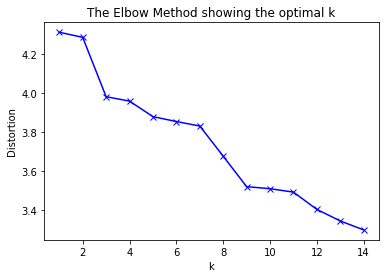

In [798]:
from scipy.spatial.distance import cdist
distortions = []
K = range(1,15)
for k in K:
    print('=========')
    print(f'k = {k}')
    kmeanModel = KMeans(init='k-means++', n_clusters=k, n_init=10, random_state=0)
    y_km = kmeanModel.fit_predict(X)
    print('Customers per cluster:')
    print(pd.DataFrame(y_km).value_counts())
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_customer.drop('Most Frequent Product', axis=1).shape[0])

import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


Choice: running kmenas with 6 clusters to identify 3 large clusters and 3 small ones. Small ones are then merged into larger ones.

In [799]:
k = 6
kmeanModel = KMeans(init='k-means++', n_clusters=k, n_init=10, random_state=0)
y_km = kmeanModel.fit_predict(X)
df_customer['Cluster'] = y_km
df_customer['Cluster'].replace([2, 4, 5], [1, 3, 3], inplace=True)
df_customer['Cluster'].replace(3, 2, inplace=True)

In [800]:
df_customer['Cluster'].value_counts()

0    3374
2     718
1     291
Name: Cluster, dtype: int64

### Exploring clusters

In [801]:
df_customer

,Quantity Sum,Quantity Mean,Quantity Min,Quantity Max,Price Mean,Price Min,Price Max,Transaction Price Sum,Transaction Price Mean,Transaction Price Min,...,WOOD S/3 CABINET ANT WHITE FINISH,VICTORIAN GLASS HANGING T-LIGHT,SET/5 RED SPOTTY LID GLASS BOWLS,WOODEN FRAME ANTIQUE WHITE,CHOCOLATE HOT WATER BOTTLE,I CAN ONLY PLEASE ONE PERSON MUG,JUMBO STORAGE BAG SUKI,ASSORTED COLOURS SILK FAN,STRAWBERRY CHARLOTTE BAG,Cluster
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346.0,87,1.933333,1,10,12.564889,1.00,142.31,797.46,17.721333,1.00,...,False,False,False,False,False,False,False,False,False,1
12347.0,828,11.661972,3,36,2.295070,0.38,12.75,1323.32,18.638310,7.80,...,False,False,False,False,False,False,False,False,False,0
12348.0,373,18.650000,1,24,0.719500,0.29,1.45,222.16,11.108000,1.00,...,False,False,False,False,False,False,False,False,False,0
12349.0,998,9.327103,1,48,8.406449,0.42,250.00,2695.29,25.189626,1.25,...,False,False,True,False,False,False,False,False,False,0
12351.0,261,12.428571,1,25,2.355238,0.42,12.75,300.93,14.330000,9.90,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283.0,322,1.483871,1,12,2.199401,0.21,10.95,619.37,2.854240,0.21,...,False,True,False,False,False,True,True,False,True,2
18284.0,495,17.068966,1,50,4.003103,0.21,50.00,486.68,16.782069,6.30,...,False,False,False,False,False,False,False,False,False,0
18285.0,145,12.083333,1,80,8.350000,0.65,50.00,427.00,35.583333,7.80,...,False,True,False,False,False,False,False,False,False,0


In [802]:
#import numpy as np
#import matplotlib.pyplot as plt

#variables = list(df_customer.select_dtypes(include=np.number).columns)

#bins = 10

#for var in variables:

#plt.hist(df_customer['Quantity Sum'], bins, histtype='bar', fill=True, alpha=0.3)
#    fig = sb.histplot(data=df_customer, x=var, hue='Cluster', bins=20, \
#                      element="step", palette=["C0", "C3", "C9"], stat="density",\
                      #common_norm=False
#                     )
#    fig.set_yscale("log")
#    plt.show()



Quantity Sum
Cluster 0 median:
288.0
Cluster 1 median:
534.0
Cluster 2 median:
1280.5


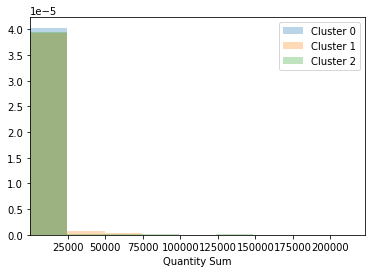

Quantity Mean
Cluster 0 median:
9.634154040404042
Cluster 1 median:
4.9
Cluster 2 median:
7.633995760466349


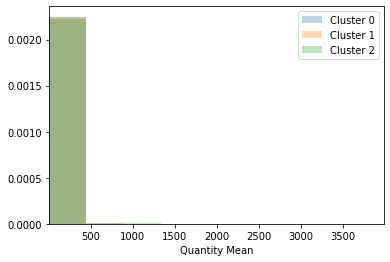

Quantity Min
Cluster 0 median:
1.0
Cluster 1 median:
1.0
Cluster 2 median:
1.0


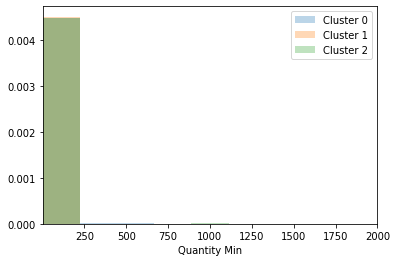

Quantity Max
Cluster 0 median:
36.0
Cluster 1 median:
36.0
Cluster 2 median:
48.0


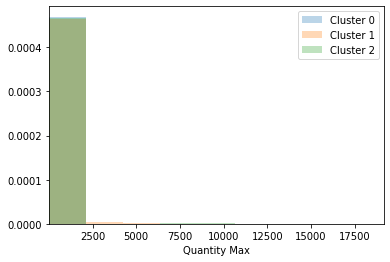

Price Mean
Cluster 0 median:
3.0390389016018307
Cluster 1 median:
3.2902631578947377
Cluster 2 median:
2.996996054211701


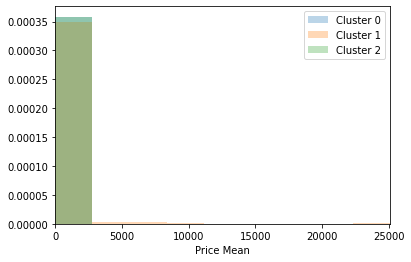

Price Min
Cluster 0 median:
0.42
Cluster 1 median:
0.38
Cluster 2 median:
0.29


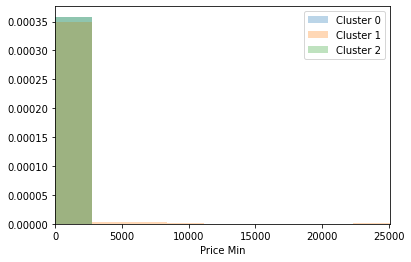

Price Max
Cluster 0 median:
10.95
Cluster 1 median:
16.95
Cluster 2 median:
14.95


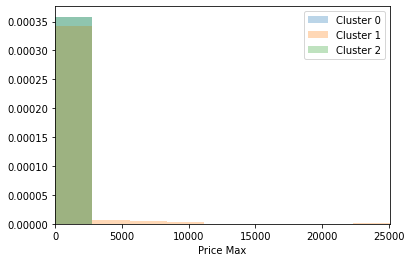

Transaction Price Sum
Cluster 0 median:
527.455
Cluster 1 median:
1141.8700000000003
Cluster 2 median:
2502.6999999999985


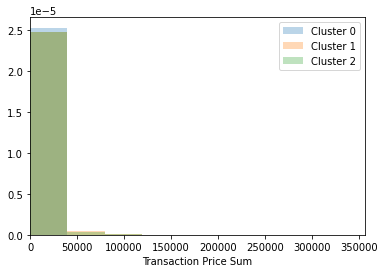

Transaction Price Mean
Cluster 0 median:
17.55644986449865
Cluster 1 median:
12.798402366863908
Cluster 2 median:
15.797018279569901


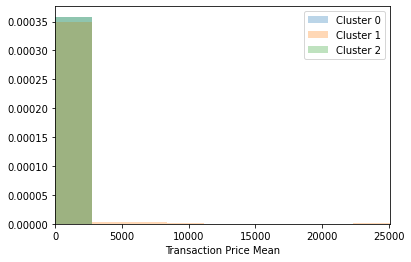

Transaction Price Min
Cluster 0 median:
5.04
Cluster 1 median:
0.85
Cluster 2 median:
0.85


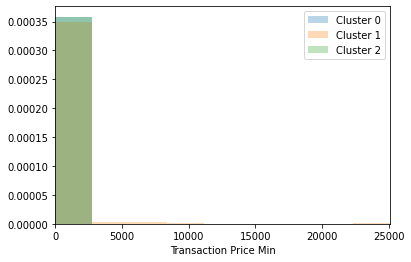

Transaction Price Max
Cluster 0 median:
51.0
Cluster 1 median:
79.95
Cluster 2 median:
76.5


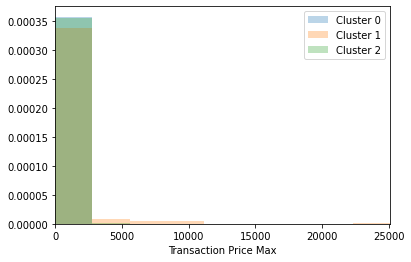

Customer Cancellation Rate
Cluster 0 median:
0.0
Cluster 1 median:
0.011695906432748537
Cluster 2 median:
0.008791251255893036


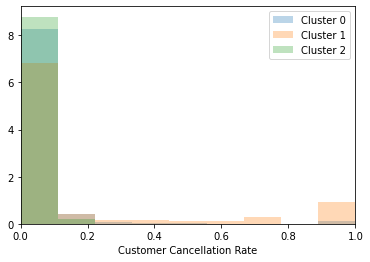

Customer With Cancellations
Cluster 0 median:
0.0
Cluster 1 median:
1.0
Cluster 2 median:
1.0


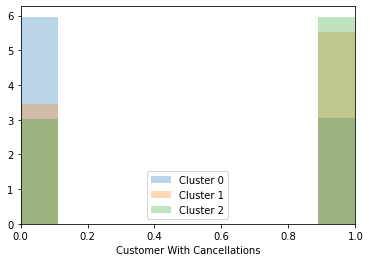

In [803]:
import numpy as np
import matplotlib.pyplot as plt

variables = list(df_customer.select_dtypes(include=np.number).columns)
variables.remove('Cluster')


for var in variables:
    print('========================')
    print(var)
    print('Cluster 0 median:')
    print(df_customer.query('Cluster==0')[var].median())
    print('Cluster 1 median:')
    print(df_customer.query('Cluster==1')[var].median())
    print('Cluster 2 median:')
    print(df_customer.query('Cluster==2')[var].median())

    fig, ax = plt.subplots()
    bins = np.linspace(df_customer[var].min(), df_customer[var].max(), 10)
    ax.set(xlim=(df_customer[var].min(), df_customer[var].max()))
    #plt.xlim(left=df_customer[var].min())
    #plt.xlim(right=df_customer[var].max())
    #plt.xlim(df_customer[var].min(), df_customer[var].max())
    plt.hist(df_customer.query('Cluster==0')[var],\
             bins=bins, alpha=0.3, density=True, label='Cluster 0')
    plt.hist(df_customer.query('Cluster==1')[var],\
            bins=bins, alpha=0.3, density=True, label='Cluster 1')
    plt.hist(df_customer.query('Cluster==2')[var],\
             bins=bins, alpha=0.3, density=True, label='Cluster 2')
    #plt.xlim(0, 300000)
    plt.xlim(df_customer[var].min(), df_customer[var].max())
    #plt.ylim(0,2100)
    plt.legend()
    plt.xlabel(var)
    #plt.yscale('log')
    plt.show()

Interpretation:
- Cluster 0: low in Quantity, lowest fraction of customers that make any cancellations.
- Cluster 1: highest prices on average, highest customer cancellation rate.
- Cluster 2: high quantity of transaction, high fraction of customers who cancel, lowest customer cancellation rate

Cluster distribution across countries:

In [630]:
df_country = pd.DataFrame((df_customer.query('Cluster==0')['Country'].\
                           value_counts())).rename(columns={'Country':'Cluster 0'})

tmp = pd.DataFrame((df_customer.query('Cluster==1')['Country'].\
                    value_counts())).rename(columns={'Country':'Cluster 1'})
df_country = pd.merge(df_country, tmp, left_index=True, right_index=True)

tmp = pd.DataFrame((df_customer.query('Cluster==2')['Country'].\
                    value_counts())).rename(columns={'Country':'Cluster 2'})
df_country = pd.merge(df_country, tmp, left_index=True, right_index=True)
df_country

,Cluster 0,Cluster 1,Cluster 2
United Kingdom,1539,943,1552
France,21,6,20
Germany,19,16,33
Spain,10,7,7
Netherlands,9,6,8
Portugal,9,7,2
Sweden,8,4,4
Belgium,8,1,7
Switzerland,7,1,5
Australia,7,3,4


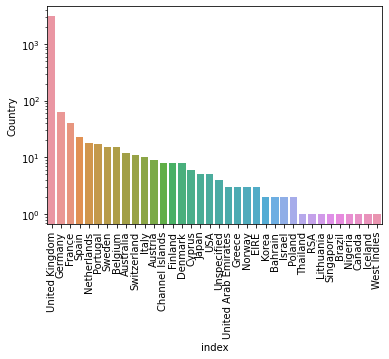

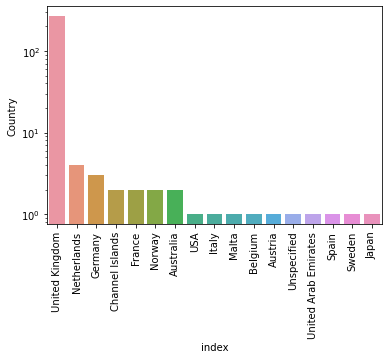

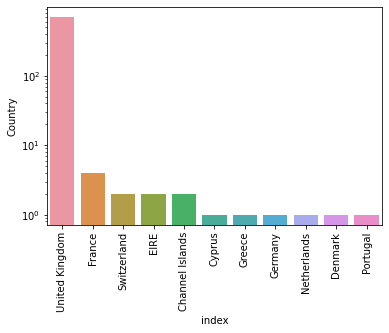

In [807]:
for cl in range(3):
    s = pd.DataFrame((df_customer.query('Cluster=='+str(cl))['Country'].value_counts())).reset_index()
    fig = sb.barplot(x='index', y='Country', data=s)
    fig.set_yscale("log")
    plt.xticks(rotation=90)
    plt.show()

Merging the cluster information back to the main fataframe.

In [574]:
df = pd.merge(df, df_customer['Cluster'], how='left', on='Customer ID')

In [631]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Cancellation', 'Transaction Price',
       'Customer Cancellation Rate', 'Customer With Cancellations',
       'Product Cancellation Rate', 'Cluster'],
      dtype='object')

Most frequently purcased

In [632]:
df.groupby('Cluster').Description.apply(list).apply(lambda l: max(set(l), key=l.count))

Cluster
0    WHITE HANGING HEART T-LIGHT HOLDER
1    WHITE HANGING HEART T-LIGHT HOLDER
2    WHITE HANGING HEART T-LIGHT HOLDER
Name: Description, dtype: object

In [812]:
for cl in range(3):
    print()
    print('==================')
    print()
    print(f'Cluster {cl}')
    print()
    s = pd.DataFrame((df.query('Cluster=='+str(cl))['Description'].value_counts()))#.reset_index()
    print(s.head(20))
    #    fig = sb.barplot(x='index', y='Description', data=s)
#    #fig.set_yscale("log")
#    plt.xticks(rotation=90)
#    plt.show()



Cluster 0

                                    Description
WHITE HANGING HEART T-LIGHT HOLDER          560
HEART OF WICKER LARGE                       395
REGENCY CAKESTAND 3 TIER                    370
REX CASH+CARRY JUMBO SHOPPER                351
HEART OF WICKER SMALL                       306
PAPER CHAIN KIT 50'S CHRISTMAS              306
ASSORTED COLOUR BIRD ORNAMENT               300
JUMBO BAG RED RETROSPOT                     278
PAPER CHAIN KIT VINTAGE CHRISTMAS           248
BAKING SET 9 PIECE RETROSPOT                242
STRAWBERRY CERAMIC TRINKET BOX              234
VINTAGE SNAP CARDS                          232
HAND WARMER OWL DESIGN                      230
RED HANGING HEART T-LIGHT HOLDER            229
HAND WARMER BIRD DESIGN                     229
SMALL POPCORN HOLDER                        228
HAND WARMER SCOTTY DOG DESIGN               226
WICKER STAR                                 223
60 TEATIME FAIRY CAKE CASES                 222
PLASTERS IN TIN VINTAGE PAI

## Train a cancellation prediction model

In [813]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Metrics
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.metrics import classification_report,confusion_matrix

# Cross-validation
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cross_val_predict
#from sklearn.model_selection import cross_validate

In [829]:
target = 'Customer With Cancellations'
#variables = list(df.select_dtypes(include=np.number).columns)
variables = list(df_customer.columns)
#variables.remove(target)
#variables.remove('Most Frequent Product')
#variables.remove('Customer Cancellation Rate')
#variables.remove('Country')

y = df_customer[target]
X = df_customer[variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(X_train.columns)

X_train_tmp = X_train.drop(columns=[target, 'Most Frequent Product', 'Customer Cancellation Rate', 'Cluster', 'Country'])
X_test_tmp = X_test.drop(columns=[target, 'Most Frequent Product', 'Customer Cancellation Rate', 'Cluster', 'Country'])

imbalance = len(y_train)/sum(y_train)

Index(['Quantity Sum', 'Quantity Mean', 'Quantity Min', 'Quantity Max',
       'Price Mean', 'Price Min', 'Price Max', 'Transaction Price Sum',
       'Transaction Price Mean', 'Transaction Price Min',
       'Transaction Price Max', 'Customer Cancellation Rate',
       'Customer With Cancellations', 'Most Frequent Product', 'Country',
       'WHITE HANGING HEART T-LIGHT HOLDER', 'POSTAGE', 'Manual',
       'REGENCY CAKESTAND 3 TIER', 'HOME BUILDING BLOCK WORD',
       'STRAWBERRY CERAMIC TRINKET BOX', 'BAKING SET 9 PIECE RETROSPOT ',
       'LUNCH BAG WOODLAND', 'REX CASH+CARRY JUMBO SHOPPER',
       'ASSORTED COLOUR BIRD ORNAMENT', 'JUMBO BAG STRAWBERRY',
       'WOOD S/3 CABINET ANT WHITE FINISH', 'VICTORIAN GLASS HANGING T-LIGHT',
       'SET/5 RED SPOTTY LID GLASS BOWLS', 'WOODEN FRAME ANTIQUE WHITE ',
       'CHOCOLATE HOT WATER BOTTLE', 'I CAN ONLY PLEASE ONE PERSON MUG',
       'JUMBO STORAGE BAG SUKI', 'ASSORTED COLOURS SILK FAN',
       'STRAWBERRY CHARLOTTE BAG', 'Cluster'],

In [830]:
X_train_tmp.columns

Index(['Quantity Sum', 'Quantity Mean', 'Quantity Min', 'Quantity Max',
       'Price Mean', 'Price Min', 'Price Max', 'Transaction Price Sum',
       'Transaction Price Mean', 'Transaction Price Min',
       'Transaction Price Max', 'WHITE HANGING HEART T-LIGHT HOLDER',
       'POSTAGE', 'Manual', 'REGENCY CAKESTAND 3 TIER',
       'HOME BUILDING BLOCK WORD', 'STRAWBERRY CERAMIC TRINKET BOX',
       'BAKING SET 9 PIECE RETROSPOT ', 'LUNCH BAG WOODLAND',
       'REX CASH+CARRY JUMBO SHOPPER', 'ASSORTED COLOUR BIRD ORNAMENT',
       'JUMBO BAG STRAWBERRY', 'WOOD S/3 CABINET ANT WHITE FINISH',
       'VICTORIAN GLASS HANGING T-LIGHT', 'SET/5 RED SPOTTY LID GLASS BOWLS',
       'WOODEN FRAME ANTIQUE WHITE ', 'CHOCOLATE HOT WATER BOTTLE',
       'I CAN ONLY PLEASE ONE PERSON MUG', 'JUMBO STORAGE BAG SUKI',
       'ASSORTED COLOURS SILK FAN', 'STRAWBERRY CHARLOTTE BAG'],
      dtype='object')

In [831]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=20,\
                              random_state=42, eval_metric=["auc"],\
                             scale_pos_weight=imbalance,\
                             use_label_encoder=False,
                             #enable_categorical=True
                             )
#eval_metric=["auc", "error", "error@0.6"]

#xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
xgb_model.fit(X_train_tmp, y_train)

y_pred = xgb_model.predict(X_test_tmp)

In [832]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[743 285]
 [163 563]]
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1028
           1       0.66      0.78      0.72       726

    accuracy                           0.74      1754
   macro avg       0.74      0.75      0.74      1754
weighted avg       0.76      0.74      0.75      1754



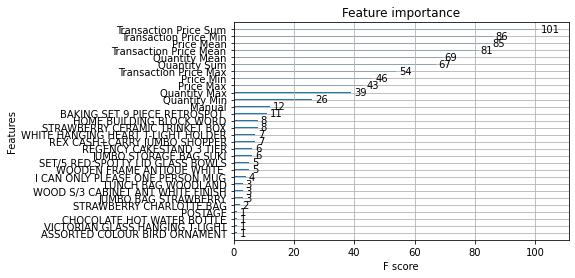

In [833]:
xgb.plot_importance(xgb_model)
plt.show()

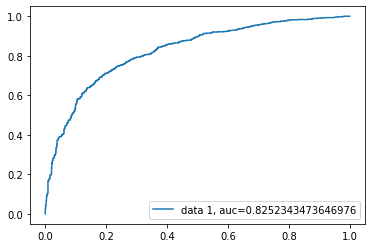

Accuracy 0.7445838084378563


In [834]:
# Draw the ROC curve

y_pred_proba = xgb_model.predict_proba(X_test_tmp)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print("Accuracy", metrics.accuracy_score(y_test, y_pred))

### Churn prediction on the test set

In [836]:
X_test['Cancellation Prediction'] = y_pred
X_test['Cancellation Probability'] = y_pred_proba

<ipython-input-836-a2de83874f0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Cancellation Prediction'] = y_pred
<ipython-input-836-a2de83874f0a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Cancellation Probability'] = y_pred_proba


In [837]:
X_test

,Quantity Sum,Quantity Mean,Quantity Min,Quantity Max,Price Mean,Price Min,Price Max,Transaction Price Sum,Transaction Price Mean,Transaction Price Min,...,SET/5 RED SPOTTY LID GLASS BOWLS,WOODEN FRAME ANTIQUE WHITE,CHOCOLATE HOT WATER BOTTLE,I CAN ONLY PLEASE ONE PERSON MUG,JUMBO STORAGE BAG SUKI,ASSORTED COLOURS SILK FAN,STRAWBERRY CHARLOTTE BAG,Cluster,Cancellation Prediction,Cancellation Probability
Customer ID,,,,,,,,,,,,,,,,,,,,,
13703.0,236,3.277778,1,12,3.248889,0.42,8.95,652.12,9.057222,0.85,...,False,False,False,False,False,False,False,0,0,0.213953
16145.0,2183,12.060773,1,96,3.401381,0.19,18.95,3060.28,16.907624,0.38,...,True,False,False,False,False,False,False,2,1,0.958212
14210.0,1851,7.944206,1,48,3.532961,0.29,16.95,3997.93,17.158498,2.50,...,True,True,False,False,False,False,False,2,1,0.844377
17199.0,232,29.000000,1,72,0.881250,0.14,2.10,135.04,16.880000,0.85,...,False,False,False,False,False,True,False,0,0,0.456258
14094.0,159,3.613636,1,42,2.713409,0.65,14.95,312.72,7.107273,0.95,...,False,False,False,False,False,False,False,0,0,0.208371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14892.0,79,6.076923,2,12,3.511538,1.25,9.95,202.35,15.565385,11.70,...,False,False,False,False,False,False,False,0,0,0.224922
13157.0,3323,20.262195,2,96,1.847317,0.21,12.75,3946.14,24.061829,5.04,...,False,False,False,False,False,True,False,0,1,0.880565
15312.0,1178,10.068376,1,25,2.975470,0.42,10.95,2015.29,17.224701,9.95,...,False,True,False,False,False,False,False,2,1,0.809562


Find the customers that are active in the second half of 2010

## Users that churned in the second half of 2010

In [838]:
l = list(df[df.InvoiceDate>pd.to_datetime('2010-06-01')].query('Cancellation == True')['Customer ID'].unique())

List of the users that made a cancellation in the second half of 2010:

In [839]:
print(f'In total {len(l)} users made a cancellation in the second half of 2010')
print()
print("User IDs of the users who made a cancellation in the second half of 2010:")
print()
print(l)

In total 1252 users made a cancellation in the second half of 2010

User IDs of the users who made a cancellation in the second half of 2010:

[13085.0, 13078.0, 18102.0, 12682.0, 13635.0, 17519.0, 15413.0, 17865.0, 13767.0, 15712.0, 15311.0, 17700.0, 14911.0, 15998.0, 12931.0, 15614.0, 16128.0, 14748.0, 13394.0, 12615.0, 14040.0, 15796.0, 15091.0, 15061.0, 14292.0, 14156.0, 13599.0, 17063.0, 15719.0, 17998.0, 15005.0, 17611.0, 15051.0, 13097.0, 13590.0, 17091.0, 12921.0, 14621.0, 14543.0, 15380.0, 16422.0, 16150.0, 12836.0, 17961.0, 13381.0, 17345.0, 17243.0, 15750.0, 15808.0, 17191.0, 17428.0, 13648.0, 16563.0, 16701.0, 15602.0, 13777.0, 14000.0, 16823.0, 16163.0, 15759.0, 12523.0, 17019.0, 16700.0, 17511.0, 12755.0, 14299.0, 17949.0, 16550.0, 12980.0, 14425.0, 13623.0, 15542.0, 13564.0, 16467.0, 14527.0, 17476.0, 14440.0, 15581.0, 17768.0, 16797.0, 14667.0, 17377.0, 16210.0, 17867.0, 14739.0, 16233.0, 17412.0, 16525.0, 13313.0, 14122.0, 12471.0, 17809.0, 15615.0, 17841.0, 13089.0, 1

In total

In [840]:
len(set(l))

1252

### Make predictions for the customers active in December 2010

In [841]:
active_customers = pd.DataFrame(df[df.InvoiceDate>pd.to_datetime('2010-12-01')].groupby('Customer ID')['Quantity'].apply(lambda x: list(x)[0]))

In [842]:
active_customers = pd.merge(active_customers, X_test, how='inner', on='Customer ID')

In [843]:
print('Number of customers from the test set that are active in December 2010:')
active_customers.shape[0]

Number of customers from the test set that are active in December 2010:


254

List of customers predicted to make a cancellation in December 2010:

In [844]:
active_customers[active_customers['Cancellation Prediction']==1].index.to_list()

[12395.0,
 12431.0,
 12471.0,
 12494.0,
 12600.0,
 12647.0,
 12649.0,
 12681.0,
 12708.0,
 12709.0,
 12720.0,
 12721.0,
 12747.0,
 12755.0,
 12766.0,
 12797.0,
 12808.0,
 12838.0,
 12841.0,
 12870.0,
 12872.0,
 12921.0,
 12963.0,
 13050.0,
 13065.0,
 13069.0,
 13077.0,
 13078.0,
 13081.0,
 13102.0,
 13115.0,
 13117.0,
 13126.0,
 13136.0,
 13173.0,
 13230.0,
 13255.0,
 13269.0,
 13319.0,
 13327.0,
 13329.0,
 13370.0,
 13418.0,
 13468.0,
 13481.0,
 13491.0,
 13579.0,
 13599.0,
 13756.0,
 13758.0,
 13769.0,
 13831.0,
 13838.0,
 13842.0,
 13958.0,
 13963.0,
 14085.0,
 14135.0,
 14142.0,
 14205.0,
 14210.0,
 14293.0,
 14404.0,
 14409.0,
 14437.0,
 14440.0,
 14443.0,
 14466.0,
 14506.0,
 14589.0,
 14688.0,
 14696.0,
 14713.0,
 14744.0,
 14766.0,
 14813.0,
 14896.0,
 14901.0,
 14911.0,
 14932.0,
 14952.0,
 14987.0,
 15005.0,
 15023.0,
 15070.0,
 15081.0,
 15100.0,
 15181.0,
 15194.0,
 15298.0,
 15311.0,
 15332.0,
 15351.0,
 15358.0,
 15502.0,
 15529.0,
 15555.0,
 15596.0,
 15602.0,
 15605.0,


In [845]:
active_customers['Cancellation Probability']

Customer ID
12347.0    0.082254
12386.0    0.204460
12395.0    0.838673
12431.0    0.927169
12441.0    0.284760
             ...   
18193.0    0.475796
18219.0    0.884480
18229.0    0.303811
18259.0    0.565861
18269.0    0.182837
Name: Cancellation Probability, Length: 254, dtype: float32

Having a look of the cancellation probability distribution:

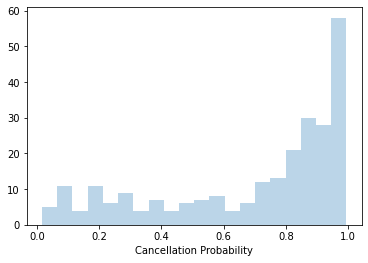

In [846]:
plt.hist(active_customers['Cancellation Probability'],\
         bins=20, alpha=0.3)
plt.xlabel('Cancellation Probability')
plt.show()

Customers with a cancellation probability above 0.9 in december 2010:

In [847]:
l = list(active_customers[active_customers['Cancellation Probability']>0.9].index)
print(f'In total {len(l)} users have a high probability of making= a cancellation in December 2010')
print()
print("User IDs of the users with a high probability of making= a cancellation in December 2010 :")
print()
print(l)

In total 84 users have a high probability of making= a cancellation in December 2010

User IDs of the users with a high probability of making= a cancellation in December 2010 :

[12431.0, 12471.0, 12600.0, 12647.0, 12681.0, 12708.0, 12709.0, 12720.0, 12747.0, 12755.0, 12766.0, 12838.0, 12921.0, 12963.0, 13050.0, 13069.0, 13077.0, 13078.0, 13081.0, 13102.0, 13126.0, 13136.0, 13319.0, 13327.0, 13329.0, 13418.0, 13468.0, 13481.0, 13599.0, 13756.0, 13758.0, 13769.0, 13831.0, 13958.0, 14135.0, 14142.0, 14440.0, 14744.0, 14766.0, 14911.0, 14952.0, 15023.0, 15181.0, 15194.0, 15298.0, 15311.0, 15332.0, 15358.0, 15502.0, 15555.0, 15596.0, 15602.0, 15694.0, 15750.0, 15769.0, 15823.0, 15827.0, 15838.0, 15955.0, 16125.0, 16168.0, 16327.0, 16422.0, 16477.0, 16550.0, 16700.0, 16713.0, 16717.0, 17069.0, 17091.0, 17346.0, 17377.0, 17412.0, 17511.0, 17677.0, 17690.0, 17700.0, 17732.0, 17735.0, 17858.0, 17873.0, 17920.0, 18055.0, 18102.0]


# Backup

In [ ]:
Customer With Cancellations


In [ ]:
df_cust_canc = pd.DataFrame(df.query('`Customer With Cancellations`==True and Cancellation==True')[df['Cancellation']==True].groupby(['Customer ID']).Description.apply(list).apply(lambda l: max(set(l), key=l.count))).rename(columns={'Description': 'Canc Most Frequent Item'})


In [74]:
df.query('`Customer With Cancellations`==True and Cancellation==True')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Cancellation,Transaction Price,Customer With Cancellations
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,True,-35.40,True
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,True,-9.90,True
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,True,-17.00,True
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,True,-12.60,True
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,True,-35.40,True
...,...,...,...,...,...,...,...,...,...,...,...
410390,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany,True,-4.20,True
410391,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom,True,-2.00,True
410392,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom,True,-2.95,True
410393,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom,True,-12.75,True


In [29]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Cancellation', 'Transaction Price'],
      dtype='object')

In [ ]:
df.groupby(['Customer ID', 'Cancellation'])

In [55]:
df_cust_canc = pd.DataFrame(df.groupby(['Customer ID', 'Cancellation']).Description.apply(list).apply(lambda l: max(set(l), key=l.count))).rename(columns={'Description': 'Most Frequent Item'})

tmp = df.groupby(['Customer ID', 'Cancellation']).Quantity.\
agg(['sum', 'mean', 'min', 'max']).rename(columns={'sum': 'Quantity Sum', 'mean': 'Quantity Mean', 'min': 'Quantity Min', 'max': 'Quantity Max'})
df_cust_canc = pd.concat([df_cust_canc, tmp], axis=1)

tmp = df.groupby(['Customer ID', 'Cancellation'])['Transaction Price'].\
agg(['sum', 'mean', 'min', 'max']).rename(columns={'sum': 'Transaction Price Sum', 'mean': 'Transaction Price Mean', 'min': 'Transaction Price Min', 'max': 'Transaction Price Max'})
df_cust_canc = pd.concat([df_cust_canc, tmp], axis=1)

In [56]:
df_cust_canc

Most Frequent Item  Quantity Sum  \
Customer ID Cancellation                                                     
12346.0     False                    This is a test product.            70   
            True                                      Manual           -17   
12347.0     False               3D DOG PICTURE PLAYING CARDS           828   
12348.0     False                PACK OF 72 SKULL CAKE CASES           373   
12349.0     False                     LOVE HEART SOCK HANGER           993   
...                                                      ...           ...   
18285.0     False             GLASS CAKE STAND MIRRORED BASE           145   
18286.0     False         DOORMAT FANCY FONT HOME SWEET HOME           608   
            True                         GOLD  CHERRY LIGHTS           -16   
18287.0     False               SCOTTIE DOG HOT WATER BOTTLE          1427   
            True                COFFEE MUG CAT + BIRD DESIGN            -2   

                          Quantity Mean  Quantity Min  Quantity Max  \
Customer ID Cancellation                                              
12346.0     False              2.121212             1            10   
            True              -1.416667            -4            -1   
12347.0     False             11.661972             3            36   
12348.0     False             18.650000             1            24   
12349.0     False              9.735294             1            48   
...                                 ...           ...           ...   
18285.0     False             12.083333             1            80   
18286.0     False              9.074627             1            36   
            True              -5.333333            -8            -4   
18287.0     False             16.788235             1            60   
            True              -2.000000            -2            -2   

                          Transaction Price Sum  Transaction Price Mean  \
Customer ID Cancellation                                                  
12346.0     False                        372.86               11.298788   
            True                        -424.60              -35.383333   
12347.0     False                       1323.32               18.638310   
12348.0     False                        222.16               11.108000   
12349.0     False                       2671.14               26.187647   
...                                         ...                     ...   
18285.0     False                        427.00               35.583333   
18286.0     False                       1296.43               19.349701   
            True                        -108.00              -36.000000   
18287.0     False                       2345.71               27.596588   
            True                          -5.10               -5.100000   

                          Transaction Price Min  Transaction Price Max  
Customer ID Cancellation                                                
12346.0     False                          1.00                  45.00  
            True                        -142.31                  -1.00  
12347.0     False                          7.80                  70.80  
12348.0     False                          1.00                  17.40  
12349.0     False                          7.80                 250.00  
...                                         ...                    ...  
18285.0     False                          7.80                 204.00  
18286.0     False                          7.50                  74.85  
            True                         -54.00                 -27.00  
18287.0     False                          5.04                 122.40  
            True                          -5.10                  -5.10  

[6112 rows x 9 columns]

In [57]:
df_cust_canc.to_flat_index()

AttributeError: 'DataFrame' object has no attribute 'to_flat_index'

In [61]:
df_cust = pd.DataFrame(df[df['Cancellation']==True].groupby(['Customer ID']).Description.apply(list).apply(lambda l: max(set(l), key=l.count))).rename(columns={'Description': 'Canc Most Frequent Item'})

tmp = pd.DataFrame(df[df['Cancellation']!=True].groupby(['Customer ID']).Description.apply(list).apply(lambda l: max(set(l), key=l.count))).rename(columns={'Description': 'Non-canc Most Frequent Item'})
df_cust = pd.concat([df_cust, tmp], axis=1)

tmp = df[df['Cancellation']==True].groupby(['Customer ID']).Quantity.\
agg(['sum', 'mean', 'min', 'max']).\
rename(columns={'sum': 'Canc Quantity Sum', 'mean': 'Canc Quantity Mean', 'min': 'Canc Quantity Min', 'max': 'Canc Quantity Max'})
df_cust = pd.concat([df_cust, tmp], axis=1)


In [62]:
df_cust

,Canc Most Frequent Item,Non-canc Most Frequent Item,Canc Quantity Sum,Canc Quantity Mean,Canc Quantity Min,Canc Quantity Max
Customer ID,,,,,,
12346.0,Manual,This is a test product.,-17.0,-1.416667,-4.0,-1.0
12347.0,NaN,3D DOG PICTURE PLAYING CARDS,NaN,NaN,NaN,NaN
12348.0,NaN,PACK OF 72 SKULL CAKE CASES,NaN,NaN,NaN,NaN
12349.0,SET/5 RED SPOTTY LID GLASS BOWLS,LOVE HEART SOCK HANGER,-5.0,-1.000000,-1.0,-1.0
12351.0,NaN,WRAP MONSTER FUN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
18283.0,NaN,GIN + TONIC DIET METAL SIGN,NaN,NaN,NaN,NaN
18284.0,CARRIAGE,RIBBONS PURSE,-1.0,-1.000000,-1.0,-1.0
18285.0,NaN,GLASS CAKE STAND MIRRORED BASE,NaN,NaN,NaN,NaN


In [60]:
pd.DataFrame(df[df['Cancellation']==False].groupby(['Customer ID']).Description.apply(list).apply(lambda l: max(set(l), key=l.count))).rename(columns={'Description': 'Non-canc Most Frequent Item'})


,Non-canc Most Frequent Item
Customer ID,
12346.0,This is a test product.
12347.0,3D DOG PICTURE PLAYING CARDS
12348.0,PACK OF 72 SKULL CAKE CASES
12349.0,LOVE HEART SOCK HANGER
12351.0,WRAP MONSTER FUN
...,...
18283.0,GIN + TONIC DIET METAL SIGN
18284.0,RIBBONS PURSE
18285.0,GLASS CAKE STAND MIRRORED BASE
